## Семинар 3 "Определение ключевых точек лица"

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [3]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Подготовительная задача 1

Сделать из линейной регрессии nn.sequental двухслойную сеть

In [4]:
model = nn.Sequential(nn.Linear(784, 300), nn.Sigmoid(),
                          nn.Linear(300, 10), nn.LogSoftmax()
                     )
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [5]:
def emulate(train_data_loader, test_data_loader, model, optimizer, loss_fn, N):
    losses = np.zeros(N)
    test_losses = np.zeros(N)
    for i in tqdm(range(N)):
        for X, y in train_data_loader:
            X_v = Variable(X.view(X.size(0), -1))
            y_v = Variable(y, requires_grad=False)
        
            y_pred = model(X_v)
            loss = loss_fn(y_pred, y_v)
            losses[i] = max(loss.data[0], losses[i])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        for X, y in test_data_loader:
            X_v = Variable(X.view(X.size(0), -1))
            y_v = Variable(y, requires_grad=False)
            
            y_pred = model(X_v)
            loss = loss_fn(y_pred, y_v)
            test_losses[i] = max(loss.data[0], test_losses[i])
    return losses, test_losses

# Подготовительная задача 2

Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST
(повторить первый и второй пункты из прошлого задания )

In [6]:
losses, test_losses = emulate(train_loader, test_loader, model, optimizer, loss_fn, 10)

100%|██████████| 10/10 [01:30<00:00,  9.04s/it]


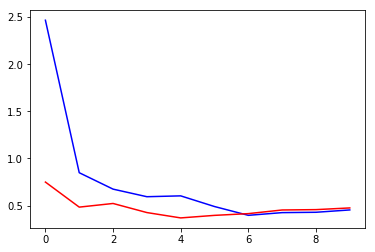

In [10]:
plt.plot([i for i in range(len(losses))], losses, c='b')
plt.plot([i for i in range(len(test_losses))], test_losses, c='r')

In [12]:
model2 = nn.Sequential(nn.Linear(784, 100), nn.ReLU(),
                          nn.Linear(100, 10), nn.LogSoftmax()
                     )
loss_fn2 = nn.NLLLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr = 0.1)

In [14]:
losses2, test_losses2 = emulate(train_loader, test_loader, model2, optimizer2, loss_fn2, 10)

100%|██████████| 10/10 [01:20<00:00,  8.09s/it]


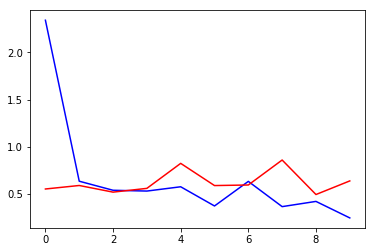

In [17]:
plt.plot([i for i in range(len(losses2))], losses2, c='b')
plt.plot([i for i in range(len(losses2))], test_losses2, c='r')

In [18]:
model3 = nn.Sequential(nn.Linear(784, 100), nn.ELU(),
                          nn.Linear(100, 10), nn.LogSoftmax()
                     )
loss_fn3 = nn.NLLLoss()
optimizer3 = torch.optim.SGD(model2.parameters(), lr = 0.1)

In [19]:
losses3, test_losses3 = emulate(train_loader, test_loader, model3, optimizer3, loss_fn3, 10)

100%|██████████| 10/10 [01:23<00:00,  8.34s/it]


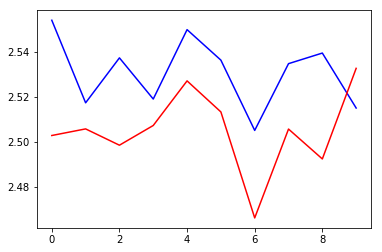

In [20]:
plt.plot([i for i in range(len(losses3))], losses3, c='b')
plt.plot([i for i in range(len(losses3))], test_losses3, c='r')

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).

In [7]:
%matplotlib inline
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name).reshape(1, -1)
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(1, -1)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [9]:
def show_landmarks(image, landmarks, landmarks2):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.scatter(landmarks2[:, 0], landmarks2[:, 1], s=10, marker='.', c='b')
    plt.pause(0.001)

In [10]:
def show(k, dataset, model, loss_fn):
    item = dataset[k]
    landmarks = item['landmarks'].reshape(-1, 2)
    y_pred = model(Variable(torch.from_numpy(item['image'])).float().cuda())
    
    print(loss_fn(y_pred, Variable(torch.from_numpy(landmarks).float(), requires_grad=False).cuda()))
    
    show_landmarks(item['image'].reshape(96, 96), y_pred.data.cpu().numpy().reshape(-1, 2), 
                   landmarks)

In [11]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                    root_dir='dataset/train/')
train_dataloader = DataLoader(train_dataset, batch_size=100, num_workers=6)

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                    root_dir='dataset/test/')
test_dataloader = DataLoader(test_dataset, batch_size=100, num_workers=6)

In [12]:
def emulate(N, model, optimizer, loss_fn):
    n_epoch = N

    losses = np.zeros(n_epoch)
    test_losses = np.zeros(n_epoch)

    for i in tqdm(range(n_epoch)):
        for batch in train_dataloader:
            X = batch['image']
            y = batch['landmarks']
            
            X = Variable(X.float()).cuda()
            y = Variable(y.float(), requires_grad=False).cuda()
    
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            losses[i] = max(loss.data[0], losses[i])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        for batch in test_dataloader:
            X = batch['image']
            y = batch['landmarks']
        
            X = Variable(X.float()).cuda()
            y = Variable(y.float(), requires_grad=False).cuda()
    
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_losses[i] = max(loss.data[0], test_losses[i])
    return losses, test_losses

In [9]:
model = nn.Sequential(nn.Linear(9216, 400), nn.Sigmoid(),
                          nn.Linear(400, 136),
                     ).cuda()
loss_fn = nn.MSELoss().cuda()

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [11]:
losses, test_losses = emulate(100, model, optimizer, loss_fn)

100%|██████████| 100/100 [02:44<00:00,  1.65s/it]


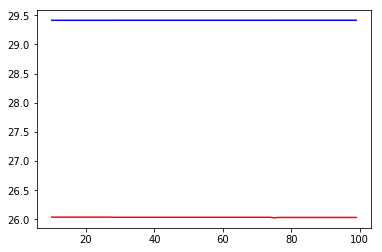

In [12]:
plt.plot([i for i in range(10, len(losses))], losses[10:], c='b')
plt.plot([i for i in range(10, len(losses))], test_losses[10:], c='r')

In [31]:
# красные – наши предсказания

Variable containing:
 8.8823
[torch.cuda.FloatTensor of size 1 (GPU 0)]



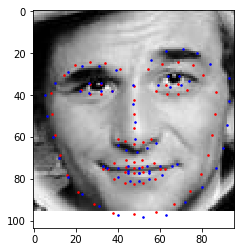

In [13]:
show(1000, train_dataset, model, loss_fn)

Variable containing:
 10.5633
[torch.cuda.FloatTensor of size 1 (GPU 0)]



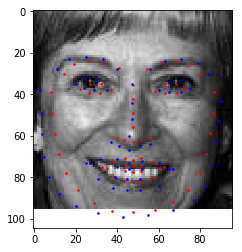

In [14]:
show(2000, train_dataset, model, loss_fn)

Variable containing:
 12.6165
[torch.cuda.FloatTensor of size 1 (GPU 0)]



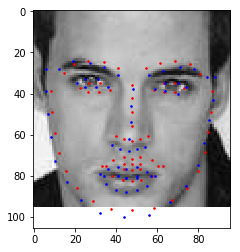

In [15]:
show(1000, test_dataset, model, loss_fn)

Variable containing:
 8.6512
[torch.cuda.FloatTensor of size 1 (GPU 0)]



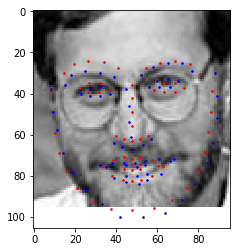

In [16]:
show(1500, test_dataset, model, loss_fn)

In [11]:
model2 = nn.Sequential(nn.Linear(9216, 400), nn.ReLU(),
                          nn.Linear(400, 136),
                     ).cuda()
loss_fn2 = nn.MSELoss().cuda()

In [12]:
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001)

In [13]:
losses2, test_losses2 = emulate(90, model2, optimizer2, loss_fn2)

100%|██████████| 90/90 [02:26<00:00,  1.63s/it]


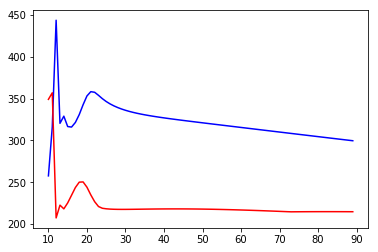

In [14]:
plt.plot([i for i in range(10, len(losses2))], losses2[10:], c='b')
plt.plot([i for i in range(10, len(losses2))], test_losses2[10:], c='r')

Variable containing:
 393.5084
[torch.cuda.FloatTensor of size 1 (GPU 0)]



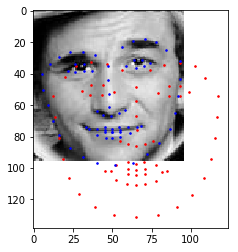

In [15]:
show(1000, train_dataset, model2, loss_fn2)

In [13]:
model3 = nn.Sequential(nn.Linear(9216, 400), nn.ELU(),
                          nn.Linear(400, 136),
                     ).cuda()
loss_fn3 = nn.MSELoss().cuda()
optimizer3 = torch.optim.Adam(model3.parameters(), lr = 0.01)

In [14]:
losses3, test_losses3 = emulate(100, model3, optimizer3, loss_fn3)

100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


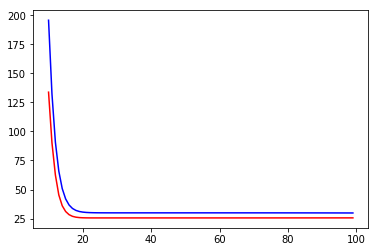

In [17]:
plt.plot([i for i in range(10, len(losses3))], losses3[10:], c='b')
plt.plot([i for i in range(10, len(losses3))], test_losses3[10:], c='r')

Variable containing:
 8.0920
[torch.cuda.FloatTensor of size 1 (GPU 0)]



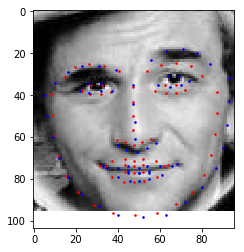

In [18]:
show(1000, train_dataset, model3, loss_fn3)

Variable containing:
 10.2233
[torch.cuda.FloatTensor of size 1 (GPU 0)]



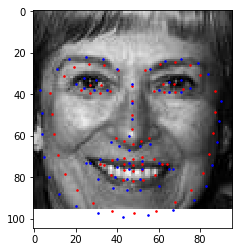

In [20]:
show(2000, train_dataset, model3, loss_fn3)

Variable containing:
 14.2192
[torch.cuda.FloatTensor of size 1 (GPU 0)]



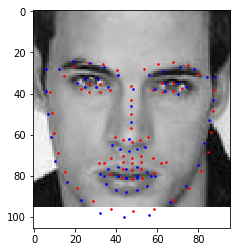

In [21]:
show(1000, test_dataset, model3, loss_fn3)

Variable containing:
 6.9501
[torch.cuda.FloatTensor of size 1 (GPU 0)]



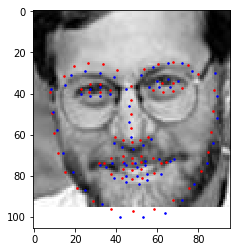

In [22]:
show(1500, test_dataset, model3, loss_fn3)